# UC-3 Frontier Fit/Evaluate

Phase26.3 notebook with executed diagnostics outputs.

## Setup

In [1]:
from __future__ import annotations

import json
from datetime import datetime, timezone
from pathlib import Path

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image, display

from veldra.api import estimate_dr, evaluate, fit, tune
from veldra.api.artifact import Artifact
from veldra.diagnostics import (
    binary_metrics,
    build_binary_table,
    build_dr_table,
    build_drdid_table,
    build_frontier_table,
    build_multiclass_table,
    build_regression_table,
    compute_balance_smd,
    compute_importance,
    compute_overlap_stats,
    compute_shap,
    compute_shap_multiclass,
    frontier_metrics,
    multiclass_metrics,
    plot_error_histogram,
    plot_feature_importance,
    plot_frontier_scatter,
    plot_if_distribution,
    plot_lift_chart,
    plot_love_plot,
    plot_nll_histogram,
    plot_parallel_trends,
    plot_pinball_histogram,
    plot_propensity_distribution,
    plot_roc_comparison,
    plot_shap_summary,
    plot_timeseries_prediction,
    plot_timeseries_residual,
    plot_true_class_prob_histogram,
    plot_weight_distribution,
    regression_metrics,
)

ROOT = Path('.').resolve()
OUT_DIR = ROOT / 'examples' / 'out' / 'phase26_2_uc03_frontier_fit_evaluate'
OUT_DIR.mkdir(parents=True, exist_ok=True)
diag_dir = OUT_DIR / 'diagnostics'
diag_dir.mkdir(parents=True, exist_ok=True)
UC_ID = 'UC-3'


/home/rem/repos/VeldraML/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Workflow

,label,pinball,mae,coverage
0,in_sample,0.127309,1.153612,0.90625
1,out_of_sample,0.170275,1.225914,0.85000


,x1,x2,y_true,fold_id,prediction,efficiency
0,0.986840,1.350625,3.090768,0,4.069273,0.759538
1,1.638156,-1.082427,5.613425,0,7.001808,0.801711
2,0.003706,0.223122,1.913426,0,3.342244,0.572497
3,0.759655,0.339875,2.699237,0,4.202740,0.642256
4,0.903573,-0.762323,3.857630,0,4.916810,0.784580
5,1.324994,-0.379807,4.989113,0,5.894106,0.846458
6,-0.629080,-0.336832,1.943890,0,2.926731,0.664185
7,-1.827239,-1.114617,-0.651623,0,1.248086,-0.522098
8,-2.018045,-0.103420,-1.618256,0,0.785337,-2.060587
9,-1.738439,-0.982019,1.911277,0,1.370461,1.394623


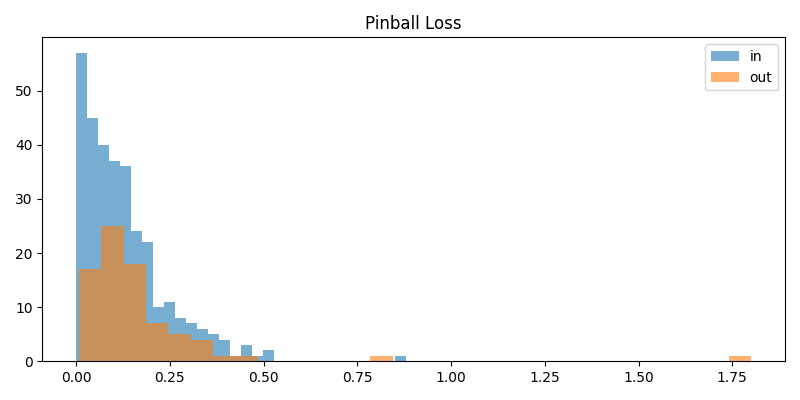

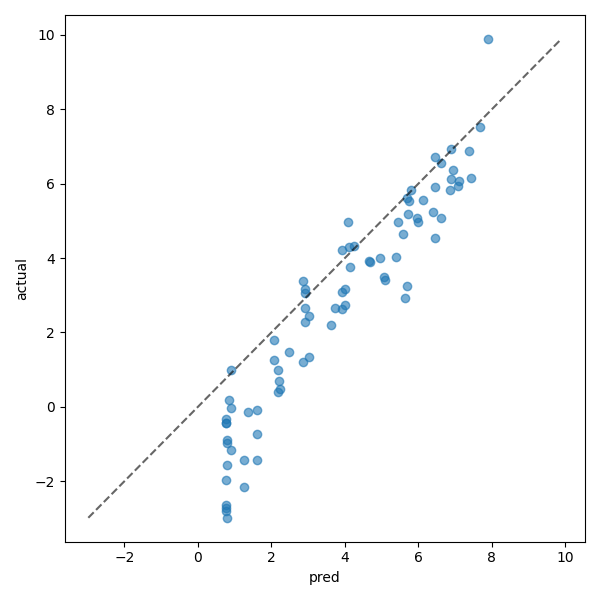

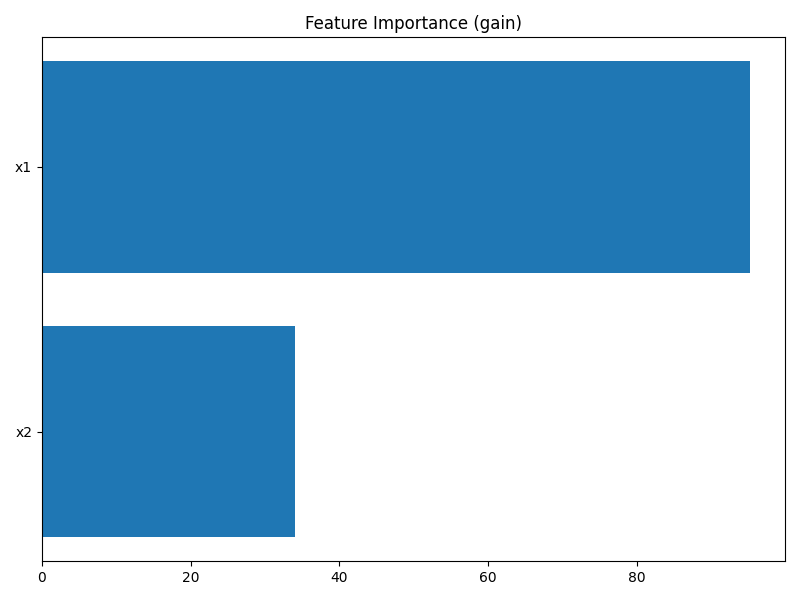

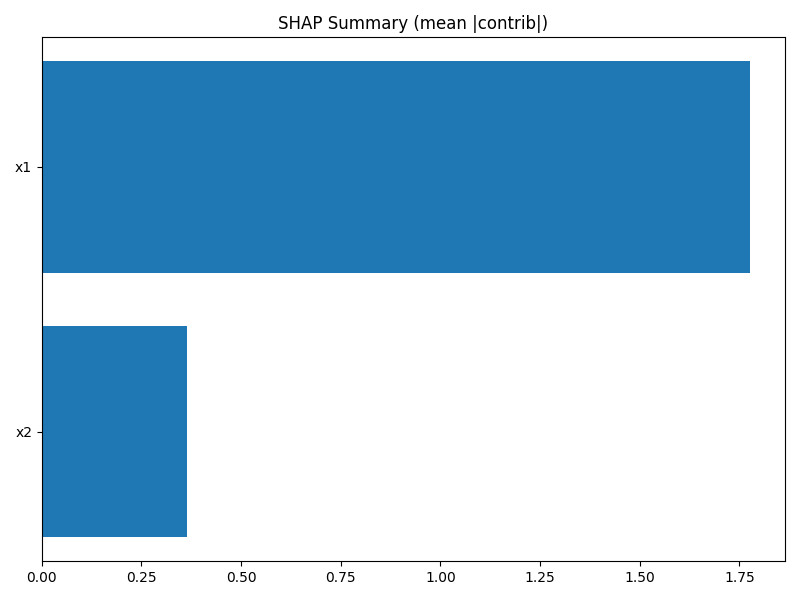

In [2]:
from sklearn.model_selection import train_test_split

alpha = 0.9
source_df = pd.read_csv(ROOT / 'examples' / 'data' / 'frontier_demo.csv').head(400)
train_df, test_df = train_test_split(source_df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_path = OUT_DIR / 'train.csv'
test_path = OUT_DIR / 'test.csv'
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

config = {
    'config_version': 1,
    'task': {'type': 'frontier'},
    'data': {'path': str(train_path), 'target': 'target'},
    'split': {'type': 'kfold', 'n_splits': 4, 'seed': 42},
    'train': {
        'seed': 42,
        'num_boost_round': 220,
        'early_stopping_rounds': 30,
        'metrics': ['quantile'],
    },
    'frontier': {'alpha': alpha},
    'export': {'artifact_dir': str(OUT_DIR / 'artifacts')},
}

run_result = fit(config)
artifact = Artifact.load(run_result.artifact_path)
eval_result = evaluate(artifact, test_df)

x_train = train_df.drop(columns=['target'])
y_train = train_df['target'].to_numpy(dtype=float)
x_test = test_df.drop(columns=['target'])
y_test = test_df['target'].to_numpy(dtype=float)
pred_train = artifact.predict(x_train)['frontier_pred'].to_numpy(dtype=float)
pred_test = artifact.predict(x_test)['frontier_pred'].to_numpy(dtype=float)

metrics_df = pd.DataFrame(
    [
        frontier_metrics(y_train, pred_train, alpha=alpha, label='in_sample'),
        frontier_metrics(y_test, pred_test, alpha=alpha, label='out_of_sample'),
    ]
)
metrics_path = OUT_DIR / 'metrics.csv'
metrics_df.to_csv(metrics_path, index=False)

pinball_train = np.maximum(alpha * (y_train - pred_train), (alpha - 1.0) * (y_train - pred_train))
pinball_test = np.maximum(alpha * (y_test - pred_test), (alpha - 1.0) * (y_test - pred_test))
pinball_path = diag_dir / 'pinball_hist.png'
plot_pinball_histogram(pinball_train, pinball_test, pinball_path)
scatter_path = diag_dir / 'frontier_scatter.png'
plot_frontier_scatter(y_test, pred_test, scatter_path)

booster = artifact._get_booster()
importance_df = compute_importance(booster, importance_type='gain', top_n=20)
importance_path = diag_dir / 'importance_gain.png'
plot_feature_importance(importance_df, 'gain', importance_path)
importance_df.to_csv(OUT_DIR / 'importance_gain.csv', index=False)

shap_frame = compute_shap(booster, x_train.head(min(len(x_train), 64)))
shap_path = diag_dir / 'shap_summary.png'
plot_shap_summary(shap_frame, x_train.head(min(len(x_train), 64)), shap_path)

safe_pred = np.where(np.abs(np.concatenate([pred_train, pred_test])) < 1e-12, np.nan, np.concatenate([pred_train, pred_test]))
frontier_table = build_frontier_table(
    pd.concat([x_train, x_test], ignore_index=True),
    np.concatenate([y_train, y_test]),
    np.concatenate([
        np.zeros(len(x_train), dtype=int),
        np.ones(len(x_test), dtype=int),
    ]),
    np.concatenate([pred_train, pred_test]),
    np.concatenate([y_train, y_test]) / safe_pred,
)
score_path = OUT_DIR / 'frontier_scores.csv'
frontier_table.to_csv(score_path, index=False)

display(metrics_df)
display(frontier_table.head(10))
display(Image(filename=str(pinball_path)))
display(Image(filename=str(scatter_path)))
display(Image(filename=str(importance_path)))
display(Image(filename=str(shap_path)))

summary_outputs = [
    train_path,
    test_path,
    metrics_path,
    pinball_path,
    scatter_path,
    importance_path,
    shap_path,
    score_path,
]
artifact_path_for_summary = run_result.artifact_path


## Result Summary

In [3]:
SUMMARY = {
    "uc": UC_ID,
    "executed_at_utc": datetime.now(timezone.utc).isoformat(),
    "status": "passed",
    "artifact_path": str(artifact_path_for_summary),
    "outputs": [str(p) for p in summary_outputs],
    "metrics": metrics_df.round(6).to_dict(orient="records"),
}
(OUT_DIR / "summary.json").write_text(json.dumps(SUMMARY, indent=2), encoding="utf-8")
SUMMARY


{'uc': 'UC-3',
 'executed_at_utc': '2026-02-17T11:51:53.690833+00:00',
 'status': 'passed',
 'artifact_path': '/home/rem/repos/VeldraML/examples/out/phase26_2_uc03_frontier_fit_evaluate/artifacts/02fcf683212e45d098f89e510a258829',
 'outputs': ['/home/rem/repos/VeldraML/examples/out/phase26_2_uc03_frontier_fit_evaluate/train.csv',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc03_frontier_fit_evaluate/test.csv',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc03_frontier_fit_evaluate/metrics.csv',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc03_frontier_fit_evaluate/diagnostics/pinball_hist.png',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc03_frontier_fit_evaluate/diagnostics/frontier_scatter.png',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc03_frontier_fit_evaluate/diagnostics/importance_gain.png',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc03_frontier_fit_evaluate/diagnostics/shap_summary.png',
  '/home/rem/repos/VeldraML/examples/out/pha